In [1]:
import os
from glob import glob
RANDOM_SEED = 123

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

In [2]:
df_train = pd.read_csv('data/X_train/X_train.csv')
df_test = pd.read_csv('data/X_test/X_test.csv')
y_train = pd.read_csv('./data/y_train.csv', header=None, names=['is_letter'])

In [8]:
print(set(df_train.iloc[:,-1].to_list()))
print(set(df_test.iloc[:, -1].to_list()))

{'E', 'F', 'A', 'H', 'G', 'B', 'I', 'C', 'D'}
{'E', 'F', 'A', 'B', 'C', 'D'}


In [6]:
channels = list(set([c[:2] for c in df_train.columns if len(c) < 5])) # 选取感兴趣的5个通道
channels.sort()

In [26]:
letter_sample = df_train[y_train.is_letter.values].head(1)

array([ True, False, False, ...,  True, False, False])

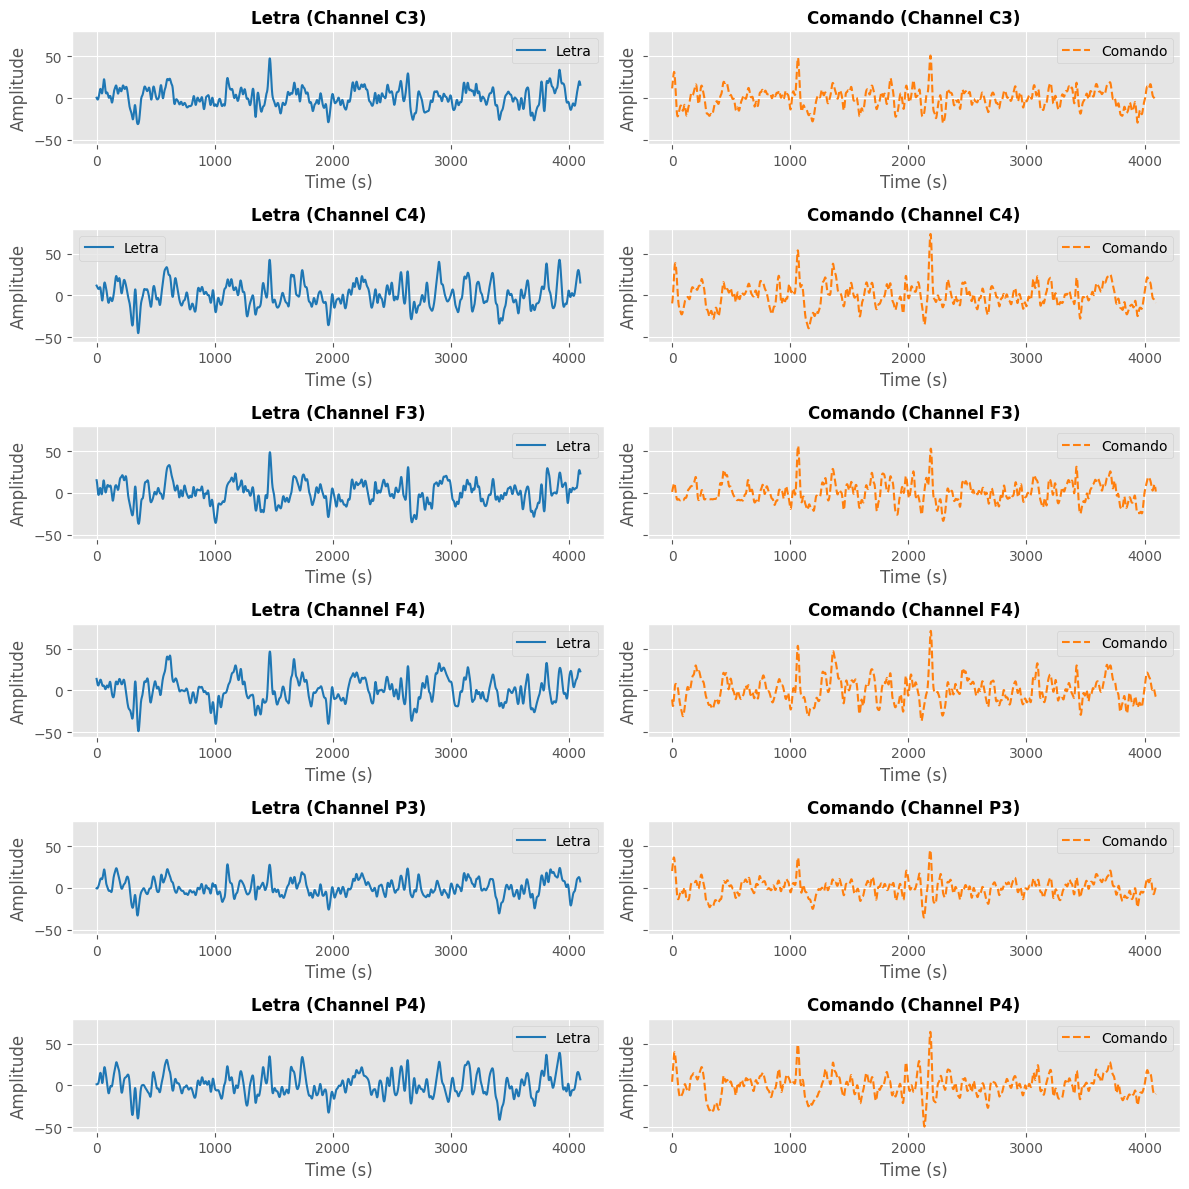

In [9]:

# 设置图形样式为现代风格
plt.style.use('ggplot')

# 创建 6x2 的子图布局
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 12), sharey=True)

# 获取示例数据
letter_sample = df_train[y_train.is_letter.values].head(1)
command_sample = df_train[~(y_train.is_letter).values].head(1)

# 设置颜色和线型
colors = ['#1f77b4', '#ff7f0e']  # 蓝色和橙色
line_styles = ['-', '--']

# 循环遍历行和列，并绘制图形
ix_channel = 0
for ix_row in range(6):
    for ix_col in range(2):
        # 设置标签和标题
        label = "Letra" if ix_col == 0 else "Comando"
        channel_cols = [c for c in df_train.columns if channels[ix_channel] in c]
        axes[ix_row, ix_col].set_title(f"{label} (Channel {channels[ix_channel]})", fontsize=12, fontweight='bold')
        
        # 绘制数据曲线
        if label == "Letra":
            axes[ix_row, ix_col].plot(letter_sample[channel_cols].values[0], 
                                      color=colors[0], linestyle=line_styles[0], label='Letra')
        else:
            axes[ix_row, ix_col].plot(command_sample[channel_cols].values[0], 
                                      color=colors[1], linestyle=line_styles[1], label='Comando')
        
        # 添加网格线
        axes[ix_row, ix_col].grid(True)
        
        # 添加X轴和Y轴标签
        axes[ix_row, ix_col].set_xlabel("Time (s)")
        axes[ix_row, ix_col].set_ylabel("Amplitude")
        
        # 增加图例
        axes[ix_row, ix_col].legend()

    ix_channel += 1

# 调整子图布局，使图形不重叠
plt.tight_layout()

# 显示图形
plt.show()


In [10]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

In [11]:
statistics = [np.mean, np.std, np.min, np.max, kurtosis, skew]

for channel in channels:
    channel_columns = [c for c in df_train.columns if channel in c]
    for stat in statistics:
        col_name = f'{channel}_{stat.__name__}'
        X_train[col_name] = stat(df_train[channel_columns], axis=1)
        X_test[col_name] = stat(df_test[channel_columns], axis=1)
X_train.head()

,C3_mean,C3_std,C3_min,C3_max,C3_kurtosis,C3_skew,C4_mean,C4_std,C4_min,C4_max,...,P3_min,P3_max,P3_kurtosis,P3_skew,P4_mean,P4_std,P4_min,P4_max,P4_kurtosis,P4_skew
0,0.592634,11.351732,-31.499783,47.372715,0.426197,0.111990,0.604357,14.145288,-45.305195,42.717160,...,-33.212685,28.271402,0.238066,-0.025419,0.659807,13.213316,-41.381460,39.135845,0.276971,0.120186
1,-0.497312,11.537114,-30.401037,50.835106,1.203746,0.265640,-0.242295,14.146621,-39.504370,73.676860,...,-35.639904,45.403046,1.862791,0.228741,-0.063983,13.297825,-49.468964,64.219980,1.937848,0.324516
2,-0.302712,13.316039,-33.753304,50.472828,0.959127,0.625852,-0.243741,15.149677,-47.240406,64.889840,...,-46.131695,46.043100,1.615524,0.442224,-0.215178,14.599125,-58.790850,57.879917,1.773842,0.316615
3,-0.078032,10.122394,-26.325730,52.605140,1.945580,0.524698,-0.096921,11.399675,-36.130260,59.071144,...,-21.457817,38.882786,1.349970,0.558519,-0.131994,10.557227,-28.362791,52.332664,1.570742,0.604802
4,0.209391,12.748181,-36.639070,49.336784,0.173969,0.052076,0.126516,16.074364,-38.013794,49.909466,...,-42.613880,42.227440,0.129564,0.185935,0.116332,16.474498,-44.715980,47.845340,-0.154902,0.325327


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 将数据转换为 PyTorch Tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# 使用 PyTorch 的 DataLoader 来封装数据
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 创建 MLP 模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(MLP, self).__init__()
        # 第一层
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        
        # 第二层
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
        # 第三层
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 第一层前向传播 + BatchNorm + ReLU + Dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # 第二层前向传播 + BatchNorm + ReLU + Dropout
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # 第三层输出
        x = self.fc3(x)
        
        return x

# 设置模型的超参数
input_size = X_train.shape[1]  # 输入特征的数量
hidden_size = 64  # 隐藏层神经元数量
num_classes = 2  # 输出类别数（字母和命令）
num_epochs = 500  # 训练轮数
learning_rate = 0.0008  # 学习率

# 初始化 MLP 模型
model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练 MLP 模型
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 在训练集上进行预测
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).argmax(dim=1)

# 打印分类报告
# print(classification_report(y_train.is_letter.values, y_pred_train.numpy()))


Epoch [1/500], Loss: 0.7273
Epoch [2/500], Loss: 0.6726
Epoch [3/500], Loss: 0.6833
Epoch [4/500], Loss: 0.6821
Epoch [5/500], Loss: 0.7139
Epoch [6/500], Loss: 0.6361
Epoch [7/500], Loss: 0.6435
Epoch [8/500], Loss: 0.6061
Epoch [9/500], Loss: 0.6789
Epoch [10/500], Loss: 0.7404
Epoch [11/500], Loss: 0.7418
Epoch [12/500], Loss: 0.6849
Epoch [13/500], Loss: 0.6296
Epoch [14/500], Loss: 0.7271
Epoch [15/500], Loss: 0.7047
Epoch [16/500], Loss: 0.7099
Epoch [17/500], Loss: 0.5829
Epoch [18/500], Loss: 0.7911
Epoch [19/500], Loss: 0.6975
Epoch [20/500], Loss: 0.6339
Epoch [21/500], Loss: 0.6674
Epoch [22/500], Loss: 0.6372
Epoch [23/500], Loss: 0.6306
Epoch [24/500], Loss: 0.7138
Epoch [25/500], Loss: 0.7709
Epoch [26/500], Loss: 0.7104
Epoch [27/500], Loss: 0.5615
Epoch [28/500], Loss: 0.7038
Epoch [29/500], Loss: 0.6361
Epoch [30/500], Loss: 0.6504
Epoch [31/500], Loss: 0.7127
Epoch [32/500], Loss: 0.6953
Epoch [33/500], Loss: 0.6551
Epoch [34/500], Loss: 0.8740
Epoch [35/500], Loss: 0

In [38]:
d = [0,8,4,5,6]
print(d[:-1])

[0, 8, 4, 5]
